<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ds-kiel/TinyML-Labs/blob/WS24-25/Lab3/Lab3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/ds-kiel/TinyML-Labs/blob/WS24-25/Lab3/Lab3.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/ds-kiel/TinyML-Labs/WS24-25/Lab3/Lab3.ipynb" download><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

---


Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. Name it *'Group\<Your group number\>_Lab1.ipynb'*. <ins>This is the master notebook so you will not be able to save your changes without copying it !</ins> Once you click on that, make sure you are working on that version of the notebook so that your work is saved.



---

# Lab 3: Pruning and pruning with quantization

In the past labs, you looked at a full TinyML pipeline using time-series data. In this lab, we leave time-series data behind and look at a standard image dataset (CIFAR10). You will explore how to [prune](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras) a network, and how to further improve space by quantizing the pruned model. **For running this lab, please use Python 3.11.**

If you like to, you can also deploy your pruned model on the microcontroller ([Arduino Nano 33 BLE Sense](https://store.arduino.cc/products/arduino-tiny-machine-learning-kit)) and test its performance there.

## Dataset: CIFAR10

The CIFAR10 dataset, is a labeled subset of the [80 million tiny images](http://people.csail.mit.edu/torralba/tinyimages/) dataset by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The CIFAR-10 dataset consists of 60000 colour images with a resolution of 32x32 pixels (input shape: (32, 32, 3)) in 10 classes, with 6000 images per class. The dataset contains 50.000 training images and 10.000 test images.

Here's an example of how the data looks:

![Example of CIFAR10 images](https://www.tensorflow.org/static/tutorials/images/cnn_files/output_K3PAELE2eSU9_0.png)


Each image in the dataset is assigned to one of the following labels:


| Label | Description |
| --- | --- |
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

You can load and split the data with

```python
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
```

## Setup

In [ ]:
# If you have not done so already, install the following dependencies
!python -m pip install tensorflow==2.14 tf-keras tensorflow-model-optimization scikit-learn edgeimpulse numpy matplotlib seaborn

### Imports

In [1]:
import numpy as np
import tempfile
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping

# from tensorflow.lite import TFLiteConverter
import tensorflow_model_optimization as tfmot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import edgeimpulse as ei

import matplotlib.pyplot as plt
import seaborn as sns

2024-12-04 11:52:26.977977: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 11:52:27.177838: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 11:52:27.177920: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 11:52:27.177981: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 11:52:27.204035: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 11:52:27.205912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

### Helper Functions

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')

def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'Model {model_name}')
    fig.set_figwidth(15)

    ax1.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'])
    ax1.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['training', 'validation'], loc='best')

    ax2.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
    ax2.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['training', 'validation'], loc='best')
    plt.show()

In [3]:
def plot_confusion_matrix(model, x_test, y_test, labels):
    cm = confusion_matrix(y_test, np.argmax(model.predict(x_test),axis=1))

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm = pd.DataFrame(cm, index = labels,
                    columns = labels)

    plt.figure(figsize = (4,4))
    ax = sns.heatmap(cm*100,
            annot=True,
            fmt='.1f',
            cmap="Blues",
            cbar=False,
                )
    ax.set_ylabel("True Class", fontdict= {'fontweight':'bold'})
    ax.set_xlabel("Predicted Class", fontdict= {'fontweight':'bold'})

    plt.show()

In [4]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [5]:
def evaluate_model(interpreter, x_test, y_test):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_results = []
    for i, test_image in enumerate(x_test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
      
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the class with highest
        # probability.
        output = interpreter.tensor(output_index)
        img_class = np.argmax(output()[0])
        prediction_results.append(img_class)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_results = np.array(prediction_results)
    accuracy = (prediction_results == np.squeeze(y_test)).mean()
    return accuracy

## Base model training

So far, you manually explored how many epochs are necessary to successfully train the model. However, Tensorflow gives you an option to automate this called [early stopping](https://keras.io/api/callbacks/early_stopping/). See also [here](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) and [here](https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd).

---
**Task 7:** Use an early stopping callback in your fitting function to find the optimal number of epochs. Use reasonable configurations. How many epochs does it train for?

**Answer:** ...

---

### Prepare Data

In [7]:
# Model / data parameters
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = len(labels)
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### Build Model

---
**Task 1:** Build an MCU-sized model for the dataset that reaches at least an accuracy of 70%. You can start with the given model below but feel free to optimive it. For the model you choose, please discuss the number of parameters it uses and why it should fit on a microcontroller.

**Answer:** ...

---

In [8]:
def CIFAR10_model(summary=False):
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    model.build()

    if summary:
        model.summary()

    return model

### Train the model

---
**Task 2:** Train your neural network and use an [early stopping](https://keras.io/api/callbacks/early_stopping/) callback in your fitting function to find the optimal number of epochs. Use reasonable configurations. How many epochs does it train for?

**Answer:** ...

---

2024-12-04 12:25:33.401991: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


Epoch 1/200
352/352 [==============================] - ETA: 0s - loss: 1.7693 - accuracy: 0.3467   

2024-12-04 12:26:21.188052: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 61440000 exceeds 10% of free system memory.


352/352 [==============================] - 48s 128ms/step - loss: 1.7693 - accuracy: 0.3467 - val_loss: 1.4834 - val_accuracy: 0.4516
Epoch 2/200
352/352 [==============================] - 47s 133ms/step - loss: 1.4254 - accuracy: 0.4886 - val_loss: 1.2630 - val_accuracy: 0.5538
Epoch 3/200
352/352 [==============================] - 42s 118ms/step - loss: 1.3003 - accuracy: 0.5357 - val_loss: 1.1632 - val_accuracy: 0.5962
Epoch 4/200
352/352 [==============================] - 46s 132ms/step - loss: 1.2188 - accuracy: 0.5646 - val_loss: 1.1098 - val_accuracy: 0.6130
Epoch 5/200
352/352 [==============================] - 41s 117ms/step - loss: 1.1604 - accuracy: 0.5888 - val_loss: 1.0616 - val_accuracy: 0.6362
Epoch 6/200
352/352 [==============================] - 44s 125ms/step - loss: 1.1121 - accuracy: 0.6069 - val_loss: 1.0069 - val_accuracy: 0.6486
Epoch 7/200
352/352 [==============================] - 45s 128ms/step - loss: 1.0674 - accuracy: 0.6263 - val_loss: 0.9547 - val_accurac

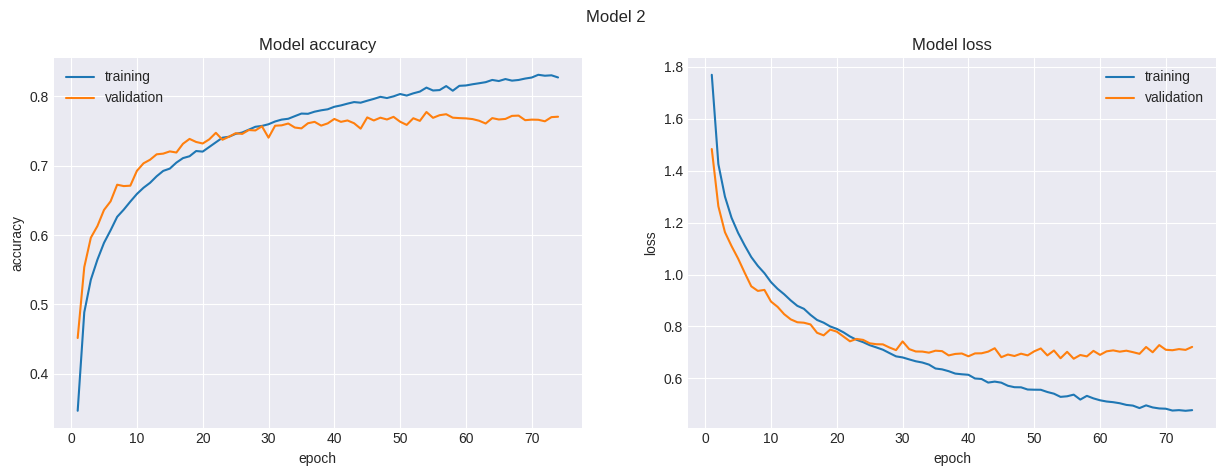

In [11]:
early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=20,
    min_delta=0.01,
    restore_best_weights=True,
    mode="min"
)

num_epochs = 200
model = CIFAR10_model()
history = model.fit(x_train, y_train, batch_size=128, epochs=num_epochs, validation_split=0.1, callbacks=[early_stopping_cb])
plot_training_history(history, 2)

### Evaluate and save the model

2024-12-04 13:19:41.918616: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


Baseline test accuracy: 0.7591000199317932
313/313 [==============================] - 5s 15ms/step


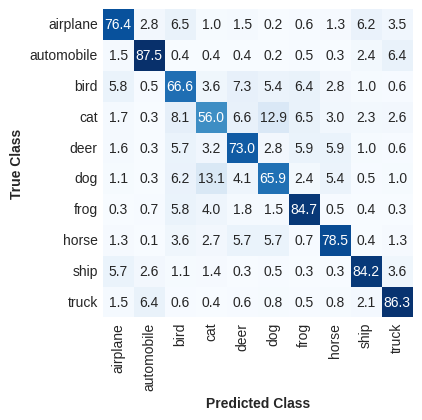

Saved baseline model to: keras_model.h5


/tmp/ipykernel_5142/1399250888.py:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, keras_file, include_optimizer=False)


In [12]:
_, baseline_model_accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

plot_confusion_matrix(model, x_test, y_test, labels)

keras_file = "keras_model.h5"
keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

313/313 [==============================] - 5s 14ms/step


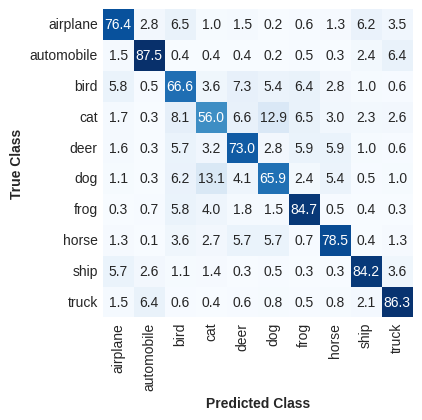

In [15]:
loaded_model = keras.saving.load_model(keras_file)
plot_confusion_matrix(loaded_model, x_test, y_test, labels)

## Quantization Aware Training (for comparison)

---
**Task 3:** Perform quantization aware training for comparison.

---

In [16]:

quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(loaded_model)
q_aware_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_es = q_aware_model.fit(x_train, y_train, batch_size=128,
                              epochs=num_epochs, validation_split=0.1, callbacks=[early_stopping_cb])
plot_training_history(history_es, 2)

Epoch 1/200


/home/glinren/uni_kiel/lab3/lib64/python3.11/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


124/352 [=========>....................] - ETA: 39s - loss: 0.5524 - accuracy: 0.7974  

KeyboardInterrupt: 

### Evaluate and save the model

In [ ]:
_, q_aware_model_accuracy = q_aware_model.evaluate(x_test, y_test, verbose=0)

print('Quantization aware test accuracy:', q_aware_model_accuracy)

plot_confusion_matrix(q_aware_model, x_test, y_test, labels)

_, q_aware_file = tempfile.mkstemp('.h5')
keras.models.save_model(q_aware_model, q_aware_file, include_optimizer=False)
print('Saved baseline model to:', q_aware_file)

### Convert the model to LiteRT and save it

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_litert_model = converter.convert()

_, quantized_litert_file = tempfile.mkstemp('.tflite')

with open(quantized_litert_file, 'wb') as f:
  f.write(quantized_litert_model)

print('Saved quantized and pruned TFLite model to:', quantized_litert_file)

## Pruning

---
**Task 4:** Create a model for [pruning](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras#fine-tune_pre-trained_model_with_pruning) and explain it. Feel free to change the code and try other things. Also have a look at this [guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide).

**Answer:** ...

---

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after ... epochs.
batch_size = 128
epochs = ...
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=...
                                                               final_sparsity=...
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()


---
**Task 5:** Look at some of the weights of the network.

---

In [ ]:
model_for_pruning.weights[2]


---
**Task 6:** Train the model and explain the callbacks used.

**Answer:** ...

---

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(x_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)


---
**Task 7:** Compare the weights of the same layer to the state before pruning. What changed?

**Answer:** ...

---

In [ ]:
model_for_pruning.weights[2]

### Evaluate and save the pruned model

In [ ]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   x_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

### Prepare the pruned model for export

---
**Task 8:** Prepare the pruned model for export. How did the number of parameters change?

**Answer:** ...

---

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.summary()

_, pruned_keras_file = tempfile.mkstemp('.h5')
keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)


---
**Task 9:** Convert the pruned model to LiteRT.

---

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_litert_model = converter.convert()

_, pruned_litert_file = tempfile.mkstemp('.tflite')

with open(pruned_litert_file, 'wb') as f:
  f.write(pruned_litert_model)

print('Saved pruned TFLite model to:', pruned_litert_file)


---
**Task 10:** Quantize the pruned model.

---

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_litert_model = converter.convert()

_, quantized_and_pruned_litert_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_litert_file, 'wb') as f:
  f.write(quantized_and_pruned_litert_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_litert_file)

## Evaluation

---
**Task 10:** Compare the size of the models and create a plot for comparison.

**Task 11:** Compare the performance of the models and create a plot for comparison.

---

In [ ]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped quantized Keras model: %.2f bytes" % (get_gzipped_model_size(q_aware_file)))
print("Size of gzipped quantized LiteRT model: %.2f bytes" % (get_gzipped_model_size(quantized_litert_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned LiteRT model: %.2f bytes" % (get_gzipped_model_size(pruned_litert_file)))
print("Size of gzipped pruned and quantized LiteRT model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_litert_file)))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_litert_model)
interpreter.allocate_tensors()

quantized_test_accuracy = evaluate_model(interpreter, x_test, y_test)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_litert_model)
interpreter.allocate_tensors()

pruned_quantized_test_accuracy = evaluate_model(interpreter, x_test, y_test)

In [ ]:
print('Accuracy of baseline Keras model:', baseline_model_accuracy)
print('Accuracy of quantized Keras model:', q_aware_model_accuracy)
print('Accuracy of pruned Keras model:', model_for_pruning_accuracy)
print('Accuracy of quantized LiteRT model:', quantized_test_accuracy)
print('Accuracy of pruned and quantized LiteRT model:', pruned_quantized_test_accuracy)


## (Optional) On-device execution


---
**Task 12 (Optional):** Convert the pruned and quantized LiteRT model to a LiteRT for microcontroller program.

**Task 13 (Optional):** Write an Arduino program that predicts the class of a CIFAR10 image transferred to the Arduino through the serial interface.

---